In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)

import matplotlib.pyplot as plt
import seaborn as sns

# Adjust path if needed
df = pd.read_csv(
    r"C:\Users\OEM\datascience\mini project 3\marketing_campaign_cleaned.csv"
)

df.shape, df.head()


((200000, 14),
                company campaign_type target_audience duration channel_used  \
 0  Innovate Industries         Email       Men 18-24  30 days   Google Ads   
 1       NexGen Systems         Email     Women 35-44  60 days   Google Ads   
 2    Alpha Innovations    Influencer       Men 25-34  30 days      YouTube   
 3   DataTech Solutions       Display        All Ages  60 days      YouTube   
 4       NexGen Systems         Email       Men 25-34  15 days      YouTube   
 
    conversion_rate  acquisition_cost   roi     location  language  clicks  \
 0             0.04               NaN  6.29      Chicago   Spanish     506   
 1             0.12               NaN  5.61     New York    German     116   
 2             0.07               NaN  7.18  Los Angeles    French     584   
 3             0.11               NaN  5.55        Miami  Mandarin     217   
 4             0.05               NaN  6.50  Los Angeles  Mandarin     379   
 
    impressions  engagement_score     c

In [2]:
# 1 = high ROI, 0 = low ROI (threshold = 5)
df['high_roi'] = (df['roi'] > 5).astype(int)

print(df['high_roi'].value_counts())
print("\nClass balance (%):")
print(df['high_roi'].value_counts(normalize=True) * 100)


high_roi
1    100056
0     99944
Name: count, dtype: int64

Class balance (%):
high_roi
1    50.028
0    49.972
Name: proportion, dtype: float64


In [3]:
y = df['high_roi']

X = df.drop(
    columns=['high_roi', 'roi', 'campaign_id', 'date'],  # drop leakage + IDs
    errors='ignore'
)

X.shape, X.head()


((200000, 13),
                company campaign_type target_audience duration channel_used  \
 0  Innovate Industries         Email       Men 18-24  30 days   Google Ads   
 1       NexGen Systems         Email     Women 35-44  60 days   Google Ads   
 2    Alpha Innovations    Influencer       Men 25-34  30 days      YouTube   
 3   DataTech Solutions       Display        All Ages  60 days      YouTube   
 4       NexGen Systems         Email       Men 25-34  15 days      YouTube   
 
    conversion_rate  acquisition_cost     location  language  clicks  \
 0             0.04               NaN      Chicago   Spanish     506   
 1             0.12               NaN     New York    German     116   
 2             0.07               NaN  Los Angeles    French     584   
 3             0.11               NaN        Miami  Mandarin     217   
 4             0.05               NaN  Los Angeles  Mandarin     379   
 
    impressions  engagement_score     customer_segment  
 0         1922   

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((160000, 13), (40000, 13))

In [5]:
# Explicit numeric feature list
num_cols = ['conversion_rate', 'clicks', 'impressions', 'engagement_score']

# Everything else in X is treated as categorical
cat_cols = [c for c in X.columns if c not in num_cols]

print("Numeric columns:", num_cols)
print("\nCategorical columns:", cat_cols)


Numeric columns: ['conversion_rate', 'clicks', 'impressions', 'engagement_score']

Categorical columns: ['company', 'campaign_type', 'target_audience', 'duration', 'channel_used', 'acquisition_cost', 'location', 'language', 'customer_segment']


In [6]:
def make_preprocessor(num_cols, cat_cols):
    return ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
        ]
    )


In [7]:
# Logistic Regression
log_reg_model = Pipeline(steps=[
    ('preprocessor', make_preprocessor(num_cols, cat_cols)),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Random Forest
rf_model = Pipeline(steps=[
    ('preprocessor', make_preprocessor(num_cols, cat_cols)),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ))
])

# Gradient Boosting
gb_model = Pipeline(steps=[
    ('preprocessor', make_preprocessor(num_cols, cat_cols)),
    ('classifier', GradientBoostingClassifier(random_state=42))
])


In [8]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    # Fit
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Accuracy + report
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} - Accuracy: {acc:.3f}\n")
    print("Classification report:\n", classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
    plt.title(f"{name} - ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    return cm, roc_auc


Logistic Regression - Accuracy: 0.497

Classification report:
               precision    recall  f1-score   support

           0       0.50      0.49      0.49     19989
           1       0.50      0.51      0.50     20011

    accuracy                           0.50     40000
   macro avg       0.50      0.50      0.50     40000
weighted avg       0.50      0.50      0.50     40000



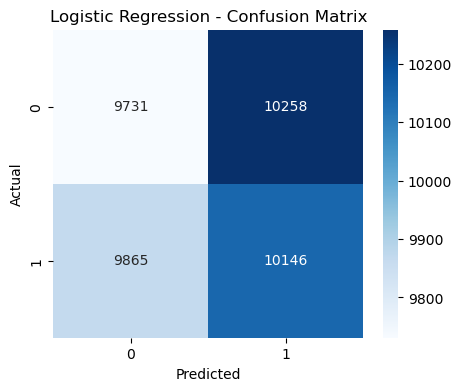

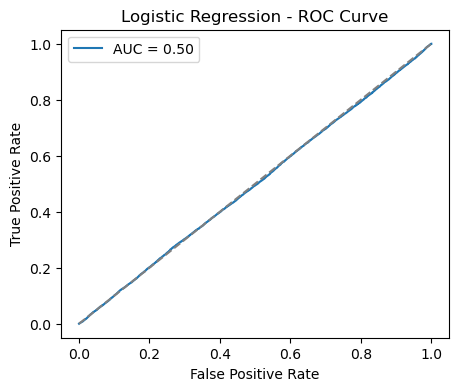

Random Forest - Accuracy: 0.500

Classification report:
               precision    recall  f1-score   support

           0       0.50      0.51      0.51     19989
           1       0.50      0.49      0.49     20011

    accuracy                           0.50     40000
   macro avg       0.50      0.50      0.50     40000
weighted avg       0.50      0.50      0.50     40000



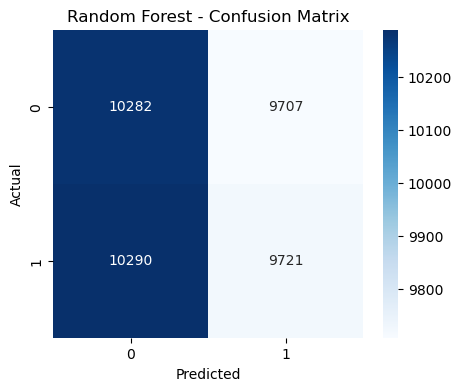

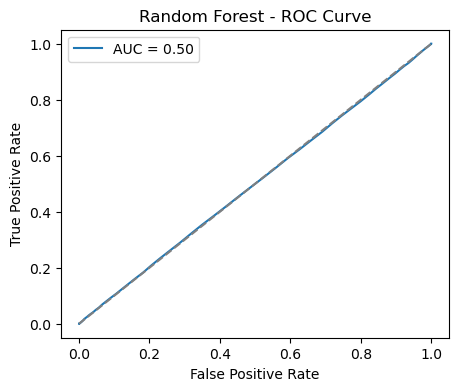

Gradient Boosting - Accuracy: 0.498

Classification report:
               precision    recall  f1-score   support

           0       0.50      0.51      0.50     19989
           1       0.50      0.49      0.49     20011

    accuracy                           0.50     40000
   macro avg       0.50      0.50      0.50     40000
weighted avg       0.50      0.50      0.50     40000



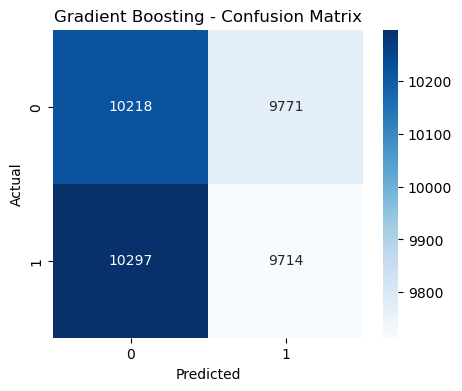

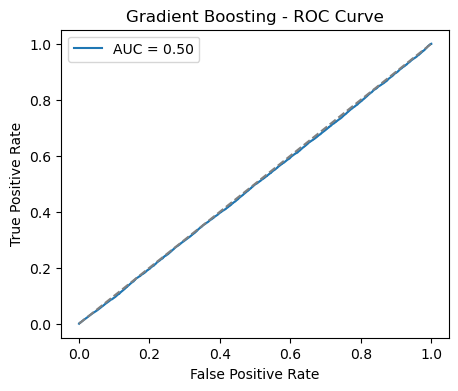

In [9]:
cm_log, auc_log = evaluate_model(
    "Logistic Regression", log_reg_model, X_train, y_train, X_test, y_test
)

cm_rf, auc_rf = evaluate_model(
    "Random Forest", rf_model, X_train, y_train, X_test, y_test
)

cm_gb, auc_gb = evaluate_model(
    "Gradient Boosting", gb_model, X_train, y_train, X_test, y_test
)


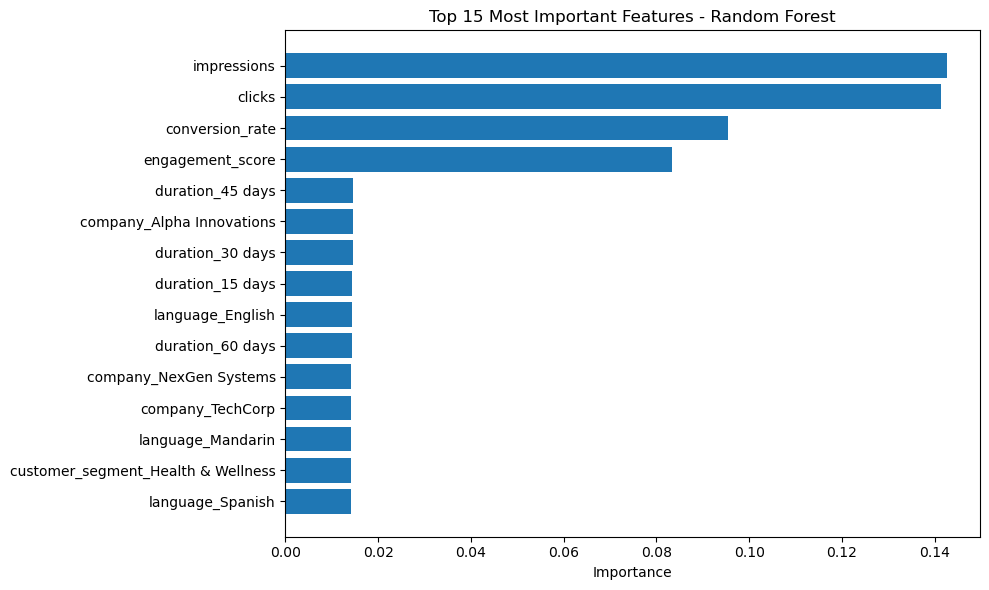

In [10]:
# Refit RF once so we can grab internals
rf_model.fit(X_train, y_train)

# Get the fitted preprocessor and classifier
preprocessor_fitted = rf_model.named_steps['preprocessor']
rf_clf = rf_model.named_steps['classifier']

# Feature names after one-hot encoding
ohe = preprocessor_fitted.named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(cat_cols)

all_feature_names = np.concatenate([num_cols, ohe_feature_names])

importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]

top_n = 15
top_features = all_feature_names[indices][:top_n]
top_importances = importances[indices][:top_n]

plt.figure(figsize=(10, 6))
plt.barh(range(top_n), top_importances[::-1])
plt.yticks(range(top_n), top_features[::-1])
plt.xlabel("Importance")
plt.title("Top 15 Most Important Features - Random Forest")
plt.tight_layout()
plt.show()


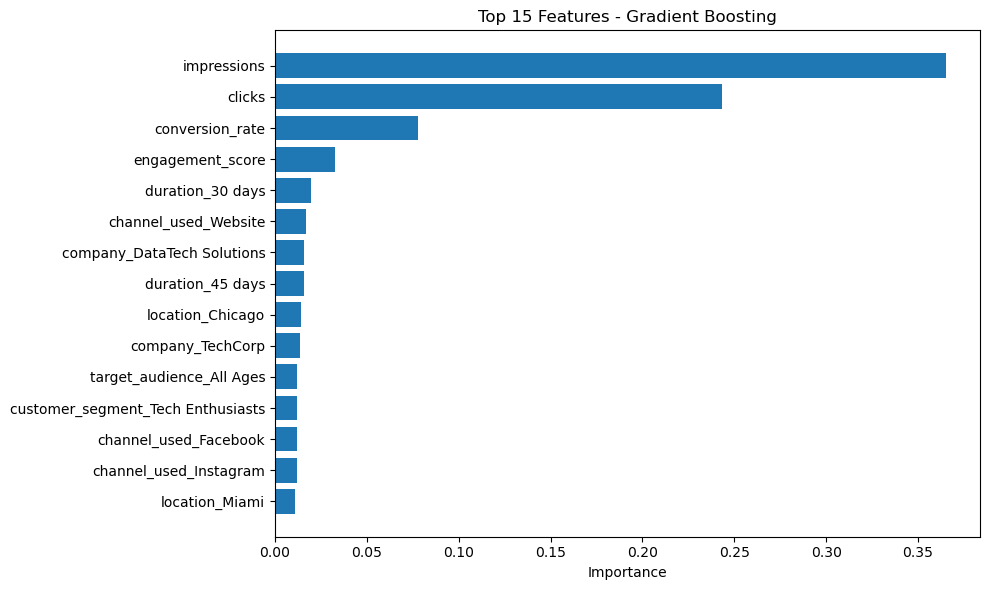

In [11]:
# Refit GB
gb_model.fit(X_train, y_train)

preprocessor_fitted_gb = gb_model.named_steps['preprocessor']
gb_clf = gb_model.named_steps['classifier']

ohe_gb = preprocessor_fitted_gb.named_transformers_['cat']
ohe_feature_names_gb = ohe_gb.get_feature_names_out(cat_cols)

all_feature_names_gb = np.concatenate([num_cols, ohe_feature_names_gb])

importances_gb = gb_clf.feature_importances_
indices_gb = np.argsort(importances_gb)[::-1]

top_n = 15
top_features_gb = all_feature_names_gb[indices_gb][:top_n]
top_importances_gb = importances_gb[indices_gb][:top_n]

plt.figure(figsize=(10, 6))
plt.barh(range(top_n), top_importances_gb[::-1])
plt.yticks(range(top_n), top_features_gb[::-1])
plt.xlabel("Importance")
plt.title("Top 15 Features - Gradient Boosting")
plt.tight_layout()
plt.show()


In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1. Scale only numeric columns
scaler = StandardScaler()
numeric_scaled = scaler.fit_transform(df[num_cols])

# 2. PCA with all numeric components
pca = PCA()
pca.fit(numeric_scaled)

explained_var = pca.explained_variance_ratio_
cum_explained = np.cumsum(explained_var)

print("Explained variance ratio:", explained_var)
print("Cumulative explained variance:", cum_explained)


Explained variance ratio: [0.2511921  0.25019502 0.24965651 0.24895637]
Cumulative explained variance: [0.2511921  0.50138712 0.75104363 1.        ]


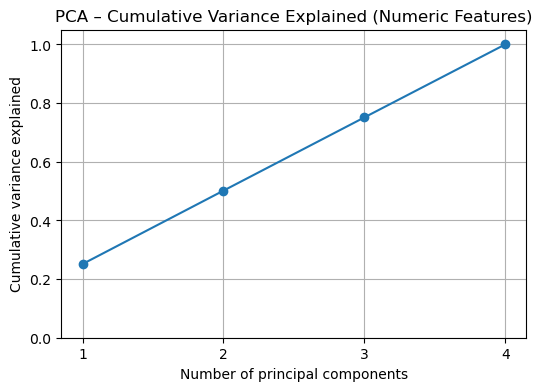

In [13]:
n_components = len(explained_var)
x_axis = np.arange(1, n_components + 1)

plt.figure(figsize=(6, 4))
plt.plot(x_axis, cum_explained, marker='o')
plt.xticks(x_axis)
plt.ylim(0, 1.05)
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative variance explained")
plt.title("PCA – Cumulative Variance Explained (Numeric Features)")
plt.grid(True)
plt.show()


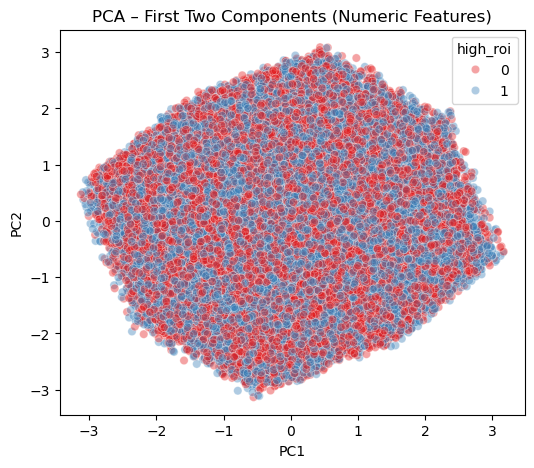

In [14]:
pca_2 = PCA(n_components=2)
numeric_pca_2 = pca_2.fit_transform(numeric_scaled)

pca_df = pd.DataFrame(numeric_pca_2, columns=['PC1', 'PC2'])
pca_df['high_roi'] = df['high_roi'].values

plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='high_roi',
    palette='Set1',
    alpha=0.4
)
plt.title("PCA – First Two Components (Numeric Features)")
plt.legend(title='high_roi')
plt.show()
